In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import cPickle
import errno

In [72]:
alpha_values_base = [0.001, 0.01, 0.1, 1, 10, 100]
alpha_values_str = [str(a) for a in alpha_values_base]
alpha_values_v2 = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
alpha_values_v2_str = [str(a) for a in alpha_values_v2]

# Main function

In [47]:
def create_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [18]:
def load_positives_negatives_dict():
    phonemes = [ "Y", "f", "c", "x", "G", "d", "b", "g", "z", "w", "N", "B", "rr", "u", "p", "D", "y", "k", "m", "t", "l", "i", "r", "n", "s", "o", "a", "e"]
    positive_values = [ 53, 682, 405, 590, 222, 773, 528, 887, 189, 743, 911, 428, 491, 1948, 1657, 920, 2453, 1708, 3234, 2938, 3505, 4929, 3650, 7152, 7555, 8040, 10144, 10597]
    negative_values = [10, 10, 105, 153, 643, 89, 395, 114, 997, 500, 443, 1169, 1739, 482, 1055, 2009, 574, 1472, 686, 1542, 1373, 1238, 2617, 476, 480, 2077, 2069, 3484 ]
    positives_dict = dict(zip(phonemes, positive_values))
    negatives_dict = dict(zip(phonemes, negative_values))
    return (positives_dict, negatives_dict)

In [19]:
def load_baselines():
    degrees = [3, 4, 5, 6]
    baseline_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/main_experiments/legendre_lasso_regression/best_alpha/baselines/"
    baselines_dicc = {}
    
    for degree in degrees:
        degree_str = "degree_" + str(degree)
        baseline_filename = baseline_dir + degree_str
        with open(baseline_filename, "rb") as f:
            baselines = cPickle.load(f)
        baselines_dicc[degree] = baselines
       
    # keys: ['baseline_ols', 'baseline_numpy_legendre']
    return baselines_dicc
    

In [20]:
def anotate(plt, xs, ys, delta, baseline):
    text = "Delta: " + "%.2f" % delta
    min_value = np.min(np.array(ys))
    min_index = list(ys).index(min_value)
    if delta > 0:
        ymin = baseline
        ymax = min_value
    else:
        ymin = min_value
        ymax = baseline
    plt.plot([xs[min_index], xs[min_index]], [ymin, ymax], color="red", linestyle=":", linewidth=1.5)
    plt.annotate(text, xy=(xs[1], np.sort(ys)[-3]))

In [10]:
# La función main recibe como parametro la carpeta de donde levanta los EERs y un output dir
# donde dumpear los resultados

In [75]:
def main(eer_degree_dir, csv_filename, plots_dir, degree, alpha_values, alpha_values_str):
    #degree_str = "degree_" + str(degree)
    #base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/eer_main/" + degree_str + "/"
    #base_dir = eers_dir + degree_str + "/"
    baselines_dicc = load_baselines()
    results = []
    #alpha_values_str = [str(a) for a in alpha_values]
    
    for alpha in alpha_values_str:
        with open(eer_degree_dir + alpha, "r") as f:
            result = f.read()
        result = result.split("\n")
        result = [l.split(": ") for l in result]
        result = [r for r in result if len(r) == 2]
        if len(result) != 28:
            raise Exception("Phonemes are not complete")
        results.append(result)
    
    positives_dict, negatives_dict = load_positives_negatives_dict()
    base_matrix = np.array(results[0])
    phonemes = base_matrix[:, 0]
    n_positives = np.array([positives_dict[phoneme] for phoneme in phonemes]).reshape(-1,1)
    n_negatives = np.array([negatives_dict[phoneme] for phoneme in phonemes]).reshape(-1,1)
    n_total = np.array([positives_dict[phoneme] + negatives_dict[phoneme] for phoneme in phonemes]).reshape(-1,1)

    for i in range(1, len(results)):
        new_column = np.array(results[i])[:, 1].reshape(-1,1)
        base_matrix = np.hstack((base_matrix, new_column))
    
    base_matrix = np.hstack((base_matrix, n_positives))
    base_matrix = np.hstack((base_matrix, n_negatives))
    base_matrix = np.hstack((base_matrix, n_total))

    dataframe = pd.DataFrame(base_matrix[:, 1:], index=phonemes, columns=alpha_values + ['n_positives', 'n_negatives', 'n_total'])
    #output_base_dir = "/Users/lmatayoshi/pronunciation-scoring/spanish_adults/experiments_legendre/output/exp1/default/"
    #output_base_dir_2 = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/"
    #output_filename = output_base_dir + "csvs/" + degree_str
    #csvs_dir = 
    #output_filename_2 = output_dir + "csvs/" + degree_str + ".csv"
    
    #plots_base_dir = output_dir + "plots/"
    #plots_base_dir = output_base_dir_2 + "plots_adjusting_intervals/"
    #plots_dir = plots_base_dir + degree_str + "/"
    
    for index, row in dataframe.iterrows():  
        xs = row.index[:len(alpha_values)]
        ys = np.array(row[:len(alpha_values)]).astype(np.float)
        baseline_numpy = baselines_dicc[degree]['baseline_numpy_legendre'][index]
        baseline = baselines_dicc[degree]['baseline_ols'][index]
        plt.semilogx(xs, list(ys))
        plt.axhline(y=baseline, linestyle="--", color="black")
        delta = (np.min(ys) - baseline) / baseline
        anotate(plt, xs, ys, delta, baseline)

        #title = "Grado " + str(degree) + ". Phoneme: "+ index + ". Positives: " + str(positives_dict[index]) + ", Negatives: " + str(negatives_dict[index])
        title = "Grado " + str(degree) + ". Phoneme: "+ index + ". Positives: " + str(row[-2]) + ", Negatives: " + str(row[-1])
        plt.title(title)
        if index in ['g', 'y', 'd', 'b', 'n']:
            index = index + "_lowercase"
        plot_filename = plots_dir + index
        plt.savefig(plot_filename)
        plt.clf()
        
    #dataframe.astype(np.float).round(2).to_csv(path_or_buf=output_filename, index_label="Phonemes")
    dataframe = dataframe.astype(np.float)
    dataframe = dataframe.sort_values(by=['n_total'])
    dataframe.round(2).to_csv(path_or_buf=csv_filename, index_label="Phonemes")
    #dataframe.astype(np.float).round(2).to_csv(path_or_buf=output_filename_2, index_label="Phonemes")
        
    

## Experiments

In [76]:
eers_base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/main_experiments/legendre_lasso_regression/best_alpha/eers/"
results_base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/main_experiments/legendre_lasso_regression/best_alpha/results/"
create_dir(results_base_dir)

In [77]:
experiments = ["all_interval", "0.01-0.1"]
min_degree = 3
max_degree = 6

In [78]:
alpha_values = {
    "all_interval": {
        "alpha_values": [0.00001, 0.0001] + alpha_values_base,
        "alpha_values_str": ["0.00001", "0.0001"] + alpha_values_str
    },
    "0.01-0.1" : {
        "alpha_values": alpha_values_v2,
        "alpha_values_str": alpha_values_v2_str
    }
}

In [81]:
for experiment in experiments:
    eers_experiment_dir = eers_base_dir + "eers_"+ experiment + "/"
    results_experiment_dir = results_base_dir + experiment + "/"
    create_dir(results_experiment_dir)
    results_experiment_plots_dir = results_experiment_dir + "plots/"
    results_experiment_csvs_dir = results_experiment_dir + "csvs/"
    create_dir(results_experiment_plots_dir)
    create_dir(results_experiment_csvs_dir)
    for deg in range(min_degree, max_degree + 1):
        degree_str = "degree_" + str(deg) 
        eer_degree_dir = eers_experiment_dir + degree_str + "/"
        plots_dir = results_experiment_plots_dir + degree_str + "/"
        create_dir(plots_dir)
        csv_filename = results_experiment_csvs_dir + degree_str
        #main(eer_degree_dir, csv_filename, plot_filename, 3, [0.00001, 0.0001] + alpha_values_base, ["0.00001", "0.0001"] + alpha_values_str)
        main(eer_degree_dir, csv_filename, plots_dir, deg, alpha_values[experiment]["alpha_values"], alpha_values[experiment]["alpha_values_str"])
        
        
        
        
        
        
        
        
        
        
        
        

# Step by step

In [119]:
def anotate(plt, xs, ys, delta, baseline):
    text = "Delta: " + "%.2f" % delta
    min_value = np.min(np.array(ys))
    min_index = list(ys).index(min_value)
    if delta > 0:
        ymin = baseline
        ymax = min_value
    else:
        ymin = min_value
        ymax = baseline
    plt.plot([xs[min_index], xs[min_index]], [ymin, ymax], color="red", linestyle=":")
    plt.annotate(text, xy=(xs[1], np.sort(ys)[-2]))

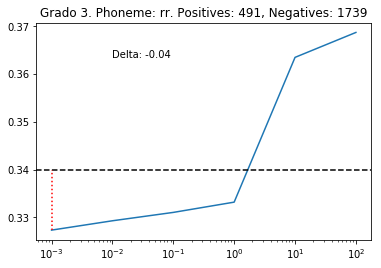

In [120]:
degree = 3
alpha_values = alpha_values_base
degree_str = "degree_" + str(degree)
base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/eer_main/" + degree_str + "/"

#alpha_values_str = [str(a) for a in alpha_values]
results = []

for alpha in alpha_values_str:
    with open(base_dir + alpha, "r") as f:
        result = f.read()
    result = result.split("\n")
    result = [l.split(": ") for l in result]
    result = [r for r in result if len(r) == 2]
    if len(result) != 28:
        raise Exception("Phonemes are not complete")
    results.append(result)

base_matrix = np.array(results[0])

for i in range(1, len(results)):
    new_column = np.array(results[i])[:, 1].reshape(-1,1)
    base_matrix = np.hstack((base_matrix, new_column))

phonemes = base_matrix[:, 0]
dataframe = pd.DataFrame(base_matrix[:, 1:], index=phonemes, columns=alpha_values)
#output_base_dir = "/Users/lmatayoshi/pronunciation-scoring/spanish_adults/experiments_legendre/output/exp1/default/"
output_base_dir_2 = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/"
#output_filename = output_base_dir + "csvs/" + degree_str
output_filename_2 = output_base_dir_2 + "csvs/" + degree_str + ".csv"

plots_base_dir = output_base_dir_2 + "plots/"
plots_dir = plots_base_dir + degree_str + "/"

try:
    os.makedirs(plots_dir)
except OSError as exception:
    ""

for index, row in dataframe.iterrows():  
    if index == "rr":
        plt.clf()
        xs = row.index
        ys = np.array(row).astype(np.float)
        plt.semilogx(list(row.index), list(ys))
        ##
        delta = (np.min(ys) - baseline[degree][index]) / baseline[degree][index]
        ##
        plt.axhline(y=baseline[degree][index], linestyle="--", color="black")
        title = "Grado " + str(degree) + ". Phoneme: "+ index + ". Positives: " + str(positives_dict[index]) + ", Negatives: " + str(negatives_dict[index])
        plt.title(title)
        
        ##
        anotate(plt, xs, ys, delta, baseline[degree][index])
        ##
        
        ##
        ##draw_distance(plt, xs, ys)
        ##
        if index in ['g', 'y', 'd', 'b', 'n']:
            index = index + "_lowercase"
        filename = plots_dir + index
        plt.savefig(filename)
        plt.show()

# DataFrame

In [333]:
phonemes = base_matrix[:, 0]
dataframe = pd.DataFrame(base_matrix[:, 1:], index=phonemes, columns=alpha_values)
output_base_dir = "/Users/lmatayoshi/pronunciation-scoring/spanish_adults/experiments_legendre/output/exp1/default/"
output_base_dir_2 = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/"
output_filename = output_base_dir + "csvs/" + degree_str
output_filename_2 = output_base_dir_2 + "csvs/" + degree_str + ".csv"
##

## Plots

In [334]:
plots_base_dir = output_base_dir_2 + "plots/"
plots_dir = plots_base_dir + degree_str + "/"
try:
	os.makedirs(plots_dir)
except OSError as exception:
	if exception.errno != errno.EEXIST:
		raise

In [335]:
for index, row in dataframe.iterrows():  
    plt.semilogx(list(row.index), list(np.array(row).astype(np.float)))
    plt.axhline(y=baseline[degree][index], linestyle="--", color="black")
    title = "Grado " + str(degree) + ". Phoneme: "+ index + ". Positives: " + str(positives_dict[index]) + ", Negatives: " + str(negatives_dict[index])
    plt.title(title)
    if index in ['g', 'y', 'd', 'b', 'n']:
        index = index + "_lowercase"
    filename = plots_dir + index
    plt.savefig(filename)
    plt.clf()

## CSV

In [127]:
dataframe.astype(np.float).round(2).to_csv(path_or_buf=output_filename, index_label="Phonemes")
dataframe.astype(np.float).round(2).to_csv(path_or_buf=output_filename_2, index_label="Phonemes")

NameError: name 'output_filename' is not defined

## Baseline

In [208]:
degrees = [3, 4, 5, 6]
baseline_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/ols_vs_numpy/Baselines/"
baselines_dicc = {}

In [209]:
for degree in degrees:
    degree_str = "degree_" + str(degree)
    baseline_filename = baseline_dir + degree_str
    with open(baseline_filename, "rb") as f:
        baselines = cPickle.load(f)
    baselines_dicc[degree] = baselines

In [220]:
baselines_dicc[3].keys()

['baseline_ols', 'baseline_numpy_legendre']

# N_instances

In [29]:
phonemes = [
    "Y",
    "f",
    "c",
    "x",
    "G",
    "d",
    "b",
    "g",
    "z",
    "w",
    "N",
    "B",
    "rr",
    "u",
    "p",
    "D",
    "y",
    "k",
    "m",
    "t",
    "l",
    "i",
    "r",
    "n",
    "s",
    "o",
    "a",
    "e"
]

In [82]:
positive_values = [
    53,
    682,
    405,
    590,
    222,
    773,
    528,
    887,
    189,
    743,
    911,
    428,
    491,
    1948,
    1657,
    920,
    2453,
    1708,
    3234,
    2938,
    3505,
    4929,
    3650,
    7152,
    7555,
    8040,
    10144,
    10597
]

negative_values = [
    10,
    10,
    105,
    153,
    643,
    89,
    395,
    114,
    997,
    500,
    443,
    1169,
    1739,
    482,
    1055,
    2009,
    574,
    1472,
    686,
    1542,
    1373,
    1238,
    2617,
    476,
    480,
    2077,
    2069,
    3484
]

positives_dict = dict(zip(phonemes, positive_values))
negatives_dict = dict(zip(phonemes, negative_values))

## Loading baselines

In [251]:
degree_str = "degree_" + str(3)
baseline_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/experiments/ols_vs_numpy/Baselines/"
baseline_filename = baseline_dir + degree_str
with open(baseline_filename, "rb") as f:
    baselines = cPickle.load(f)
baselines

{'baseline_numpy_legendre': {'B': 0.22365628405900001,
  'D': 0.239130434783,
  'G': 0.22083981337299999,
  'N': 0.21218961625300001,
  'Y': 0.33628318584099998,
  'a': 0.35498817034699998,
  'b': 0.18734177215100001,
  'c': 0.38271604938199999,
  'd': 0.39325842696500002,
  'e': 0.39732422430999997,
  'f': 0.30000000000100002,
  'g': 0.28736629083600002,
  'i': 0.25928917609000002,
  'k': 0.345788043479,
  'l': 0.27829345141799999,
  'm': 0.15510204081599999,
  'n': 0.42002237136499998,
  'o': 0.39440298507499999,
  'p': 0.30899215449599998,
  'r': 0.34388723615200001,
  'rr': 0.33467510063299999,
  's': 0.31249999999900002,
  't': 0.304969366917,
  'u': 0.36004714201600002,
  'w': 0.16150740242200001,
  'x': 0.18954248366099999,
  'y': 0.31533101045400003,
  'z': 0.247743229688},
 'baseline_ols': {'B': 0.224299065421,
  'D': 0.240915878546,
  'G': 0.23328149300000001,
  'N': 0.21295279912199999,
  'Y': 0.33628318584099998,
  'a': 0.36039266936100001,
  'b': 0.18939393939400001,
  'c'

## Drafts

In [ ]:
unsorted_phonemes = ['rr', 'B', 'D', 'G', 'N', 'Y', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'k', 'm', 'l', 'o', 'n', 'p', 's', 'r', 'u', 't', 'w', 'y', 'x', 'z']
unsorted_phonemes = np.array(unsorted_phonemes)
positives_unsorted_phonemes = [positives_dict[phoneme] for phoneme in unsorted_phonemes]
negatives_unsorted_phonemes = [negatives_dict[phoneme] for phoneme in unsorted_phonemes]